# Extraction of Feature from EEG Signal to Detect ADHD

###Faculty of Engineering of Univery of Porto 

###Master's in Data Science and Engineering

Fundamentals of Data Sciences - Signal Processing Module

December 2022

Group 5

- Barbara Zanetti Silva (202200595)
- Rendson Ribeiro Fernandes (202204390)
- Rojan Aslani (202204382)
- Farzam Salimi (201007922)
-	Diogo Cruz (202202464)


# Introduction

<font color='red'>
things to address in the introduction:

- What is ADHD?
- Different types of ADHD? 
- how many people are effected?
- difficulties of professionals to diagnose it
- Ways of diagnosis? - include EEG.
(dont forget to put references and used valid sources)
- What are brain waves? (mention a b d t g and that gamma is not used here)
add picture - also mention max frequency (to confirm aliasing theorem later)
- What is EEG?
- What is the commonly used EEG sampling frequency? discuss the aliasing theorem 
- How is it acquired?
add picture
</font>



##Objectives
In this work the primary goal is to develop an algorithm that extracts features from an EEG signal, possibly enabling the detection of signs of ADHD. In the second phase of the project it would be interesting to develop a machine learning model that can suggest diagnosis of ADHD according to the feautres of the EEG signal of the patient.  


##State of the art

<font color='red'>search for 

Automatic Detection of ADHD by EEG signal
OR
diagnostic support for ADHD dection 
OR
something like that
</font>




# Materials and Methods

## Materials
The materials used in this project were provided by NeuroImprove clinic in Porto. They consist of 11 EEG text files, 7 of them being EEG signals of patients diagnosed with ADHD, and the remaining 4 are EEG signals of patients without any diagnosed pathology. 

The signal was collected BrainMaster Discovery Hardware with a **sampling frequency of 265 Hz**, and slightly processed with NeuroGuide Software (version 3.1.0). 

In [276]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rc("font", size=14)

eeg = np.loadtxt('Control_7YO_1638C.txt')
# ADHD_7YO_846C.txt

In [277]:
pd.DataFrame(eeg).shape

(78848, 19)

Each EEG file cosists of 19 columns. Each column is data from 1 channel. Each channel represents each electrode that is placed on the scalp of the patient. In this project we decided to choose channel 7 to work with, as this channel's electrode is placed on the center of the head. Other channels are as valid to be used. 

In [278]:
eeg = eeg[:,7]      # choose column 7

In [279]:
N = len(eeg)
f_s = 265             # sampling frequency (Hz)
T_s = 1 / f_s         # sampling period (s)
t = T_s * N           # length of the data in seconds
t_vec  = np.arange(0, t, T_s) # array of numbers for seconds from 0 to t

Text(0.5, 1.0, 'Raw EEG Signal in Time Domain')

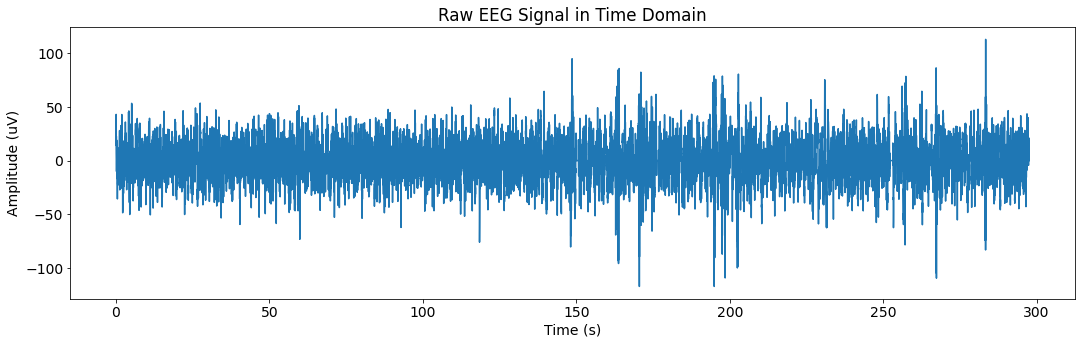

In [280]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(18)
plt.plot(t_vec, eeg)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('Raw EEG Signal in Time Domain')

The figure above shows the raw EEG signal in time domain. This figure does not tell much about the signal, so the signal is going to be converted to frequency domain to be able to analyze. To do so, in the next step **Fast Fourier Transform (FFT)** is applied to the signal. 

In [281]:
import scipy.fftpack as fft

In [329]:
def my_fft(eeg):
  eeg_fft = fft.fft(eeg)
  amplitude = np.abs(eeg_fft)
  sample_freq = fft.fftfreq(eeg.size, d = T_s)
  amp_freq = np.array([amplitude, sample_freq])
  return amplitude, sample_freq, eeg_fft

In [330]:
amplitude_eeg, sample_freq_eeg, eeg_fft = my_fft(eeg)

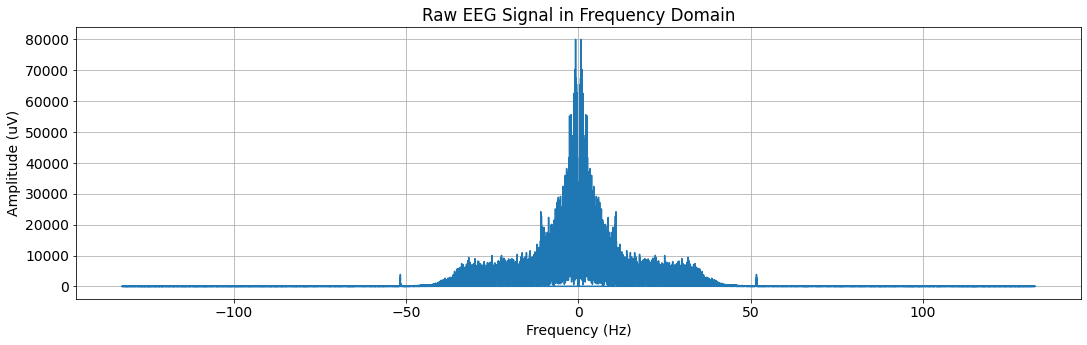

In [331]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(18)
plt.plot(sample_freq_eeg, amplitude_eeg)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (uV)')
plt.title('Raw EEG Signal in Frequency Domain')
plt.grid()

Now that we have the signal in frequency domain, we can clean the signal and apply filters and see the effect in frequency domain. Looking at the generated graph of *Raw EEG Signal in Frequency Domain*, and keeping in mind that in this project the brain waves frequencies under study lie withing the range of 0.5 to 35, it is necessary to remove the unwanted frequencies. This will be done in the next section.   

## EEG Signal Pre-Processing

To enable the detection of differences between a control and pathological EEG signal, it is necessary to reduce the noise components such as the powerline noise, baseline shift, muscle activity artefacts, etc. In this section signal pre-processing was done. 

As mentioned in the introduction, brain wave signals lie within 0.5 and 35 Hz (excluding gamma waves), hence, anything outside this interval is considered noise. Filtering the signal, which in this case implies the application of **low-pass filter** to remove frequencies higher than 35 Hz, and **high-pass filter** to remove frequencies less than 0.5 Hz. By limiting the frequencies to this interval, we are confident that the majority of the noise elements are removed, as well as the DC component (0 Hz).


In [291]:
# Ideal filter is applied (threshold) to remove unwanted frequencies
eeg_fft_filtered = eeg_fft.copy()
eeg_fft_filtered[np.abs(sample_freq_eeg) > 35] = 0
eeg_fft_filtered[np.abs(sample_freq_eeg) < 0.5] = 0

amplitude_filtered = np.abs(eeg_fft_filtered)
sample_freq_filtered = fft.fftfreq(eeg_fft_filtered.size, d = T_s)

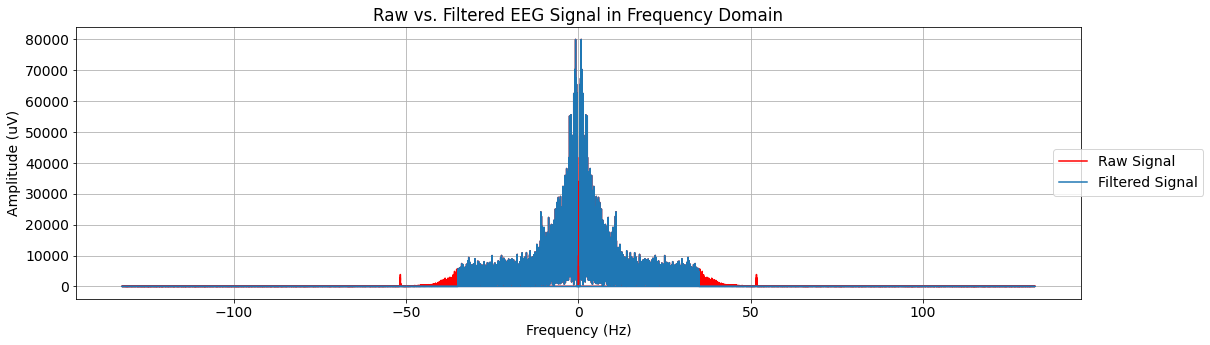

In [292]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(18)
plt.plot(sample_freq_eeg, amplitude_eeg, 'r')
plt.plot(sample_freq_filtered, amplitude_filtered)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (uV)')
plt.title('Raw vs. Filtered EEG Signal in Frequency Domain')
plt.grid()
plt.figlegend(
    labels = ('Raw Signal', 'Filtered Signal'),
    loc = 'center right', 
    frameon = True)

In Figure representing the *Filtered EEG Signal in Frequency Domain*, we can clearly see that the frequencies above 35 Hz and below 0.5 were removed. In the next step the signal will be converted back to the time domain (using the **Inverse Fast Fourier Transform**) to visually evaluate the impact of the filtering on the signal in time domain.  

In [293]:
eeg_t_clean = fft.ifft(eeg_fft_filtered)

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


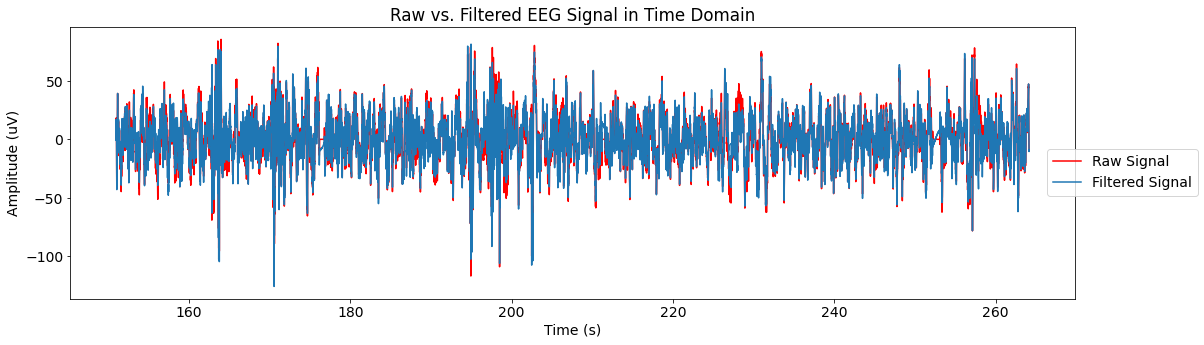

In [294]:
min = 40000
max = 70000
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(18)
plt.plot(t_vec[min:max], eeg[min:max], 'r')
plt.plot(t_vec[min:max], eeg_t_clean[min:max])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('Raw vs. Filtered EEG Signal in Time Domain')
plt.figlegend(
    labels = ('Raw Signal', 'Filtered Signal'),
    loc = 'center right', 
    frameon = True)

## EEG Wavelet Decomposition

As mentioned in the Introduction, EEG signal is composed of the sum of 4 main wavelets (Delta, Theta, Alpha, and Beta). In this section the filtered EEG signal is going to be decomposed to these wavelets for further analysis. This is done by applying **Butterworth bandpass filter of order 3**. It is important to mention that the interval of frequencies for beta wave was slightly shortened, due to its overposition with alpha wave. The overpositioning happens due to transition phase of the filter having a low slope.

In [295]:
from scipy.signal import butter, lfilter, lfilter_zi

In [296]:
# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist_frequency = 0.5 * fs
    low = lowcut / nyquist_frequency
    high = highcut / nyquist_frequency
    b, a = butter(order, [low, high], btype='band')    
    zi = lfilter_zi(b, a) * data[0]
    y, _ = lfilter(b, a, data, zi=zi)
    return y

def plot_bandpass_filter(data, title):
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    plt.subplot(4,1,1)
    fig.suptitle(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (uV)')
    plt.plot(t_vec[0:len(data)],data)    
    plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


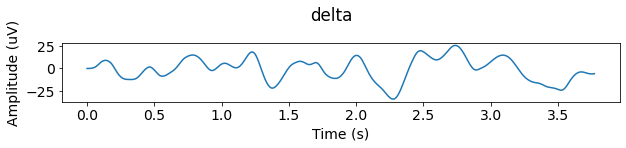

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


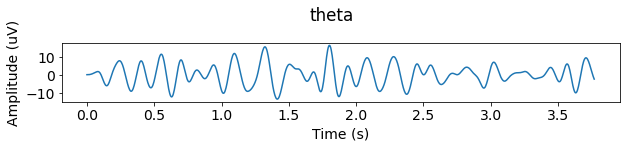

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


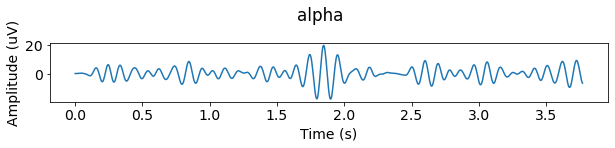

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


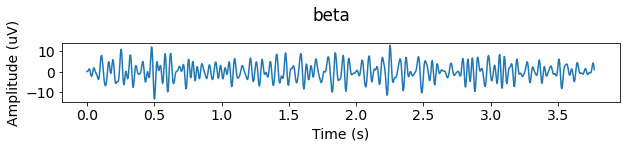

In [357]:
config_bandpass = \
  {
    "delta": [0.5, 4], # 0.5, 4
    "theta": [4, 8], # 4, 8
    "alpha": [8, 12], # 8, 12
    "beta": [14, 35] # 12, 35
  }

df_eeg_decomposed = pd.DataFrame({}) # dataframe to store wavelets

for filter in config_bandpass.keys():
  lowcut = config_bandpass.get(filter)[0]
  highcut = config_bandpass.get(filter)[1]
  bandpass_data = butter_bandpass_filter(eeg_t_clean, lowcut, highcut, fs=f_s, order = 3)
  df_eeg_decomposed[filter] = bandpass_data
  plot_bandpass_filter(bandpass_data[0:1000], filter)

As we can see in the 4 figures generated above, the EEG signal is clearly decomposed. 

<font color='red'>if possible show plot of bandpass butterworth filter itself</font>

In [358]:
amplitude_delta, sample_freq_delta, delta_fft = my_fft(df_eeg_decomposed["delta"].values)
amplitude_theta, sample_freq_theta, theta_fft = my_fft(df_eeg_decomposed["theta"].values)
amplitude_alpha, sample_freq_alpha, alpha_fft = my_fft(df_eeg_decomposed["alpha"].values)
amplitude_beta, sample_freq_beta, beta_fft = my_fft(df_eeg_decomposed["beta"].values)

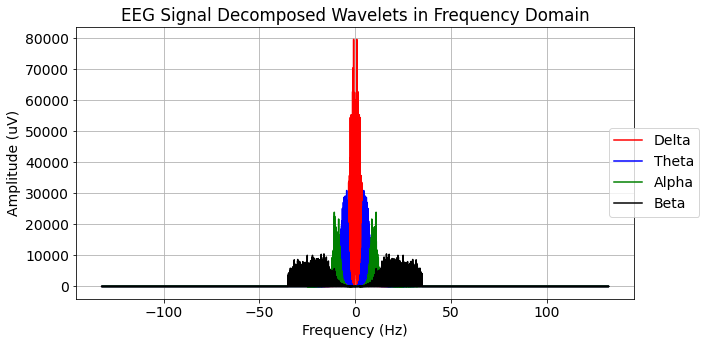

In [359]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.plot(sample_freq_delta, amplitude_delta, 'r')
plt.plot(sample_freq_theta, amplitude_theta, 'b')
plt.plot(sample_freq_alpha, amplitude_alpha, 'g')
plt.plot(sample_freq_beta, amplitude_beta, 'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (uV)')
plt.title('EEG Signal Decomposed Wavelets in Frequency Domain')
plt.grid()
plt.figlegend(
    labels = ('Delta', 'Theta', 'Alpha', 'Beta'),
    loc = 'center right', 
    frameon = True)

The signals in frequency domain also seem propperly decomposed. As mentioned earlier, the overpositioning of Beta wave and Alpha wave is due to the transition phase of the filter not beeing too steep. 

## Feature Extraction

In [ ]:
# IDEA - apply this to delta theta etc.
max_amp_pos = amp_freq[0,:].argmax() #find position of max amplitude
peak_freq = amp_freq[1,max_amp_pos]  # find the frequency with thte maximum amplitude
print(max_amp_pos)
print(peak_freq)

244
0.8200588474025974


## ADHD Prediction Model 

# Results and Discussion

mention different types of ADHD and that each one has their own type of brain waves

#Conclusions and Future Works